# Instacart Exploratory Data Analysis



## Table of Contents
- [Average Order Amount](#AOA)
- [Most Popular Products](#MPP)
- [Reordered Products](#ROP)
- [Ordering Behavior](#OB)
    *  [Time of Day](#ToD)
    *  [Day of Week](#DoW)
    *  [Rate of Reorder](#RoR)
- [Products, Departments, & Aisles Oh My!](#PDA)
- [Departments with The Most Products](#DMP)
- [Most Products Per Aisle](#MPPA)
- [Aisle's with The Most Products (Top 10)](#AMP)
- [Best Selling Department](#BSD)
- [Best Selling Aisles in Best Selling Department](#BSABSD)
- [Best Selling Aisles Overall](#BSAO)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
order_products_train = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

<a name="AOA"></a>
## Average Order Amount 
Let's start by getting an idea of how many products customers order on average

In [3]:
opp = order_products_prior
opp.tail()

,order_id,product_id,add_to_cart_order,reordered
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [4]:
opt = order_products_train
opt.tail()

,order_id,product_id,add_to_cart_order,reordered
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [5]:
opa = pd.concat([opp, opt], axis = 0) # 'order products all'
opa.tail()

,order_id,product_id,add_to_cart_order,reordered
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [6]:
# sanity check
print(len(opp))
print(len(opt))
print(len(opa))
print(opa.isnull().sum())

32434489
1384617
33819106
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


Now we can take a look at the distribution of number of products ordered

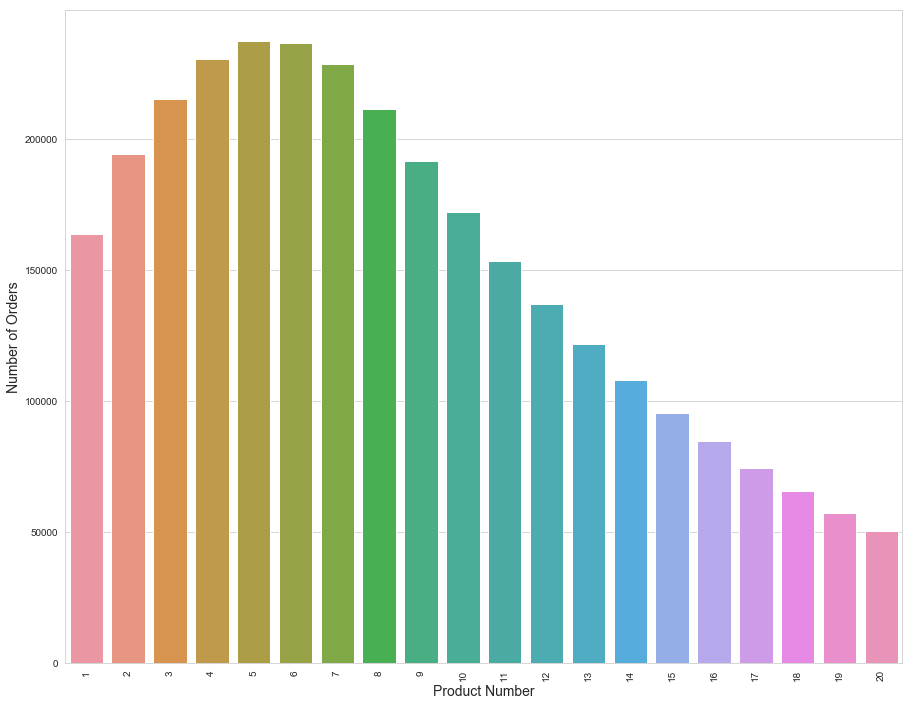

In [7]:
order_total = opa.groupby('order_id')['add_to_cart_order'].max().reset_index()
order_total = order_total.add_to_cart_order.value_counts()[:20] #nlargest(20)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation = 'vertical')
sns.barplot(order_total.index, order_total.values)

plt.ylabel('Number of Orders', fontsize = 14) 
plt.xlabel('Product Number', fontsize = 14)
#plt.xlabel('Number of Products in Order', fontsize=14)
plt.show()

From the bar chart we can see the average is 5 but with order amounts of 3-8 all totaling over 200k orders. From this we can deduce we'll want to recommend our customers somewhere in the range of 3-8 products

<a name='MPP'></a>
## Most Popular Products 
Now that we know how many products to recommend our customers. We need to figure out what those products will be. 

Like any recommendation system, for a new customer we won't know what they like so we can recommend them products based off of what they've bought previously. Instead we'll take a marketing approach and recommend what's popular since people tend to buy what they see other people buying. 

So what are our most popular items? 

In [8]:
pop = opa.groupby('product_id')['add_to_cart_order'].aggregate({'total_ordered': 'count'}).reset_index()
pop = pop.merge(products[['product_id', 'product_name']], how = 'left', on = ['product_id'])
pop = pop.sort_values(by = 'total_ordered', ascending = False)[:10]
pop

,product_id,total_ordered,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Let's visualize the data to get a better idea of how our top 10 compare.

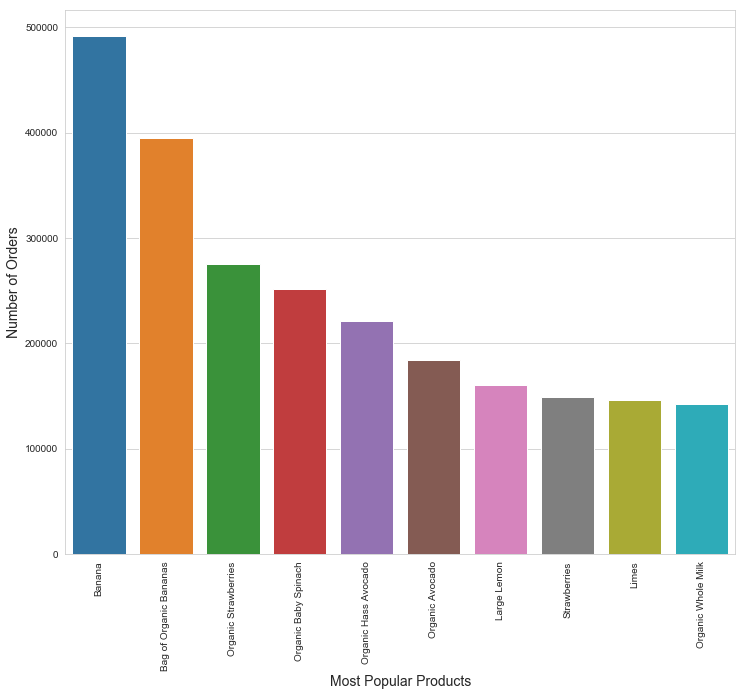

In [9]:
pop = pop.groupby(['product_name']).sum()['total_ordered'].sort_values(ascending = False)

f, ax = plt.subplots(figsize=(12,10))
sns.set_style('darkgrid')
sns.barplot(pop.index, pop.values)

plt.xticks(rotation = 'vertical')
plt.ylabel('Number of Orders', fontsize = 14)
plt.xlabel('Most Popular Products', fontsize = 14)
plt.show()

<a name='ROP'></a>
## Reordered Products 
Next we'll want to understand which products are most likely to be reordered so we can recommend products customers are likely to enjoy and buy again. 

In [10]:
reorder_ratio = opa.groupby('reordered')['product_id'].agg({'total_products': 'count'}).reset_index()
reorder_ratio['ratio'] = reorder_ratio['total_products'].apply(lambda x: x / reorder_ratio['total_products'].sum())
reorder_ratio

,reordered,total_products,ratio
0,0,13863746,0.409938
1,1,19955360,0.590062


~60% of our total orders are reorders. In other words, the bulk of our money is made in customers reordering products they like. Let's get a visual on that

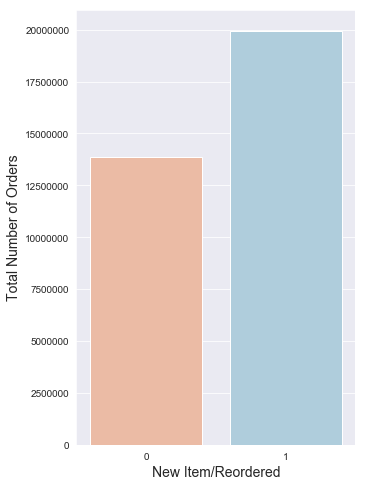

In [11]:
reorder_ratio = reorder_ratio.groupby(['reordered']).sum()['total_products'].sort_values(ascending = False)

f, ax = plt.subplots(figsize = (5,8))
sns.set_style('whitegrid')
sns.barplot(reorder_ratio.index, reorder_ratio.values, palette = 'RdBu')

plt.xlabel('New Item/Reordered', fontsize = 14)
plt.ylabel('Total Number of Orders', fontsize = 14)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()


That's a solid 6 million orders difference between the new items and the reordered prodcts. It's safe to say reordered products deserve our attention. Let's take a look at the products most likely to be reordered. Since we're looking for a percentage value here it can easily skew us to high reorder rate items that were only ordered a couple times so I'm going to set a minimum total order amount at 75. 
I tried setting the min to 1000 but 9/10 of the results were milk which isn't very useful information as store owners already know milk is a top repeat purchase item and milk is so commonplace the customer would likely buy milk regardless of if we recommended it to them. 
75 was the final min number because it was the point at which milk stopped showing up in the top results. 
Ultimately this number doesn't matter as we'll aim to recommend the product the customer is most likely to buy regardless of how many other people bought it.

In [12]:
product_rr = opa.groupby('product_id')['reordered'].agg({'reorder_total': sum, 'order_total': 'count'}).reset_index()
product_rr['reorder_probability'] = product_rr['reorder_total'] / product_rr['order_total']
product_rr = product_rr.merge(products[['product_name', 'product_id']], how = 'left', on = 'product_id')
product_rr = product_rr[product_rr.order_total > 75].sort_values(['reorder_probability'], ascending = False)[:10]
product_rr

,product_id,reorder_total,order_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


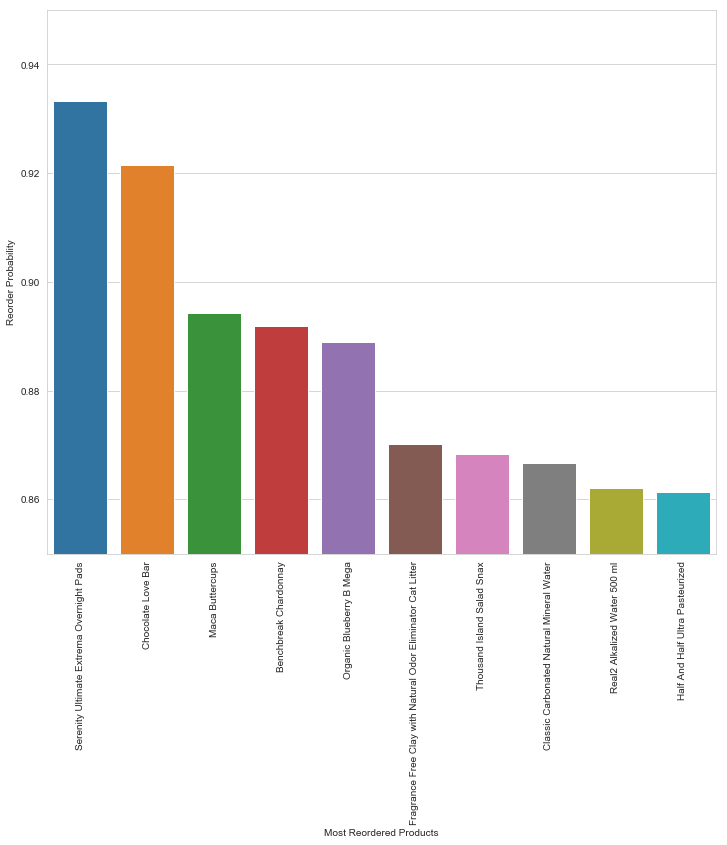

In [13]:
product_rr = product_rr.sort_values('reorder_probability', ascending = False)

plt.subplots(figsize = (12, 10))
sns.set_style('darkgrid')
sns.barplot(product_rr.product_name, product_rr.reorder_probability)
plt.ylim([.85, .95])
plt.xticks(rotation = 'vertical')
plt.xlabel('Most Reordered Products')
plt.ylabel('Reorder Probability')
plt.show()

<a name='OB'></a>
## Ordering Behavior

Now that we have a good feel about our top products, let's shift focus to how our customers tend to order

### Time of Day <a name='ToD'></a>

We'll start by understanding the time of day orders occur.

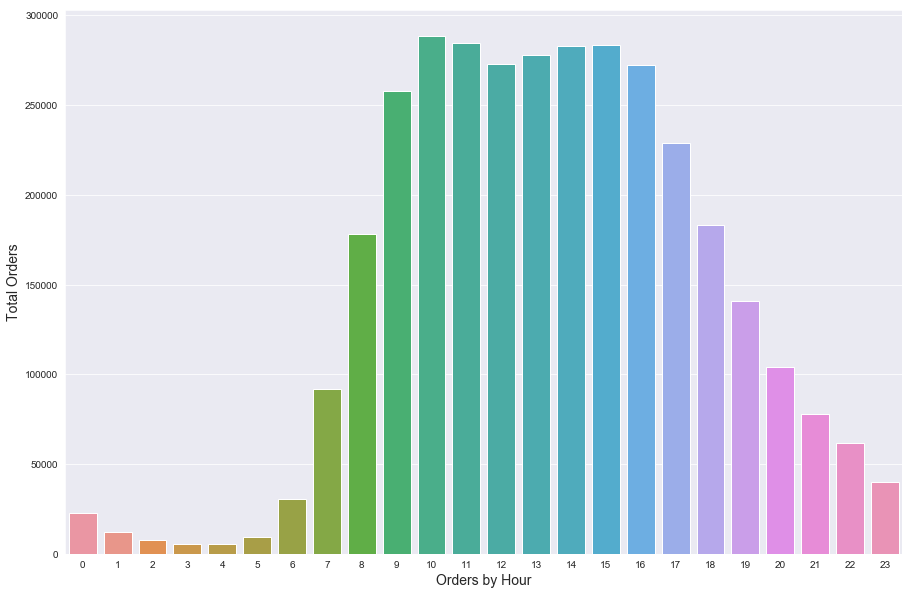

In [14]:
time_of_day = orders.groupby('order_hour_of_day')['order_id'].agg('count').reset_index()

f, ax = plt.subplots(figsize = (15, 10))
sns.barplot(time_of_day['order_hour_of_day'], time_of_day['order_id'])
plt.xlabel('Orders by Hour', fontsize = 14)
plt.ylabel('Total Orders', fontsize = 14)
plt.show()

Considering the most popular times of day fall between 9am and 5pm I'm guessing our customers mostly shop at work. We'll verify what day of the week most shopping occurs next. 
### Day of Week <a name='DoW'></a>

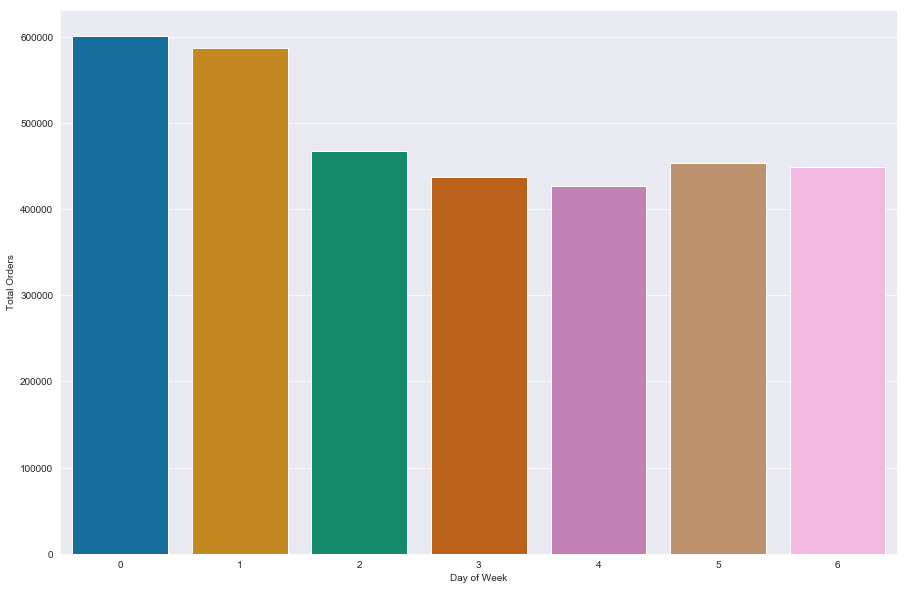

In [15]:
grouped = orders.groupby('order_dow')['order_id'].agg('count').reset_index()

f, ax = plt.subplots(figsize = (15,10))
sns.set_style('whitegrid')
current_palette = sns.color_palette('colorblind')
sns.set_palette(current_palette)
sns.barplot(x = 'order_dow', y = 'order_id', data = grouped)
plt.xlabel('Day of Week')
plt.ylabel('Total Orders')
plt.show()

Unfortunately, we don't have information on how Instacart labeled their day of week data so we're not sure what days these numbers line up with. Based off the graph, two days of the week dominate though. 

Those two days can be the weekend, since people shop on weekends.

We'll tentatively conclude the weekend is when most people buy their groceries. 
<a name='RoR'></a>
### Rate of Reorder 

Next we'll examine how often a typical customer orders.

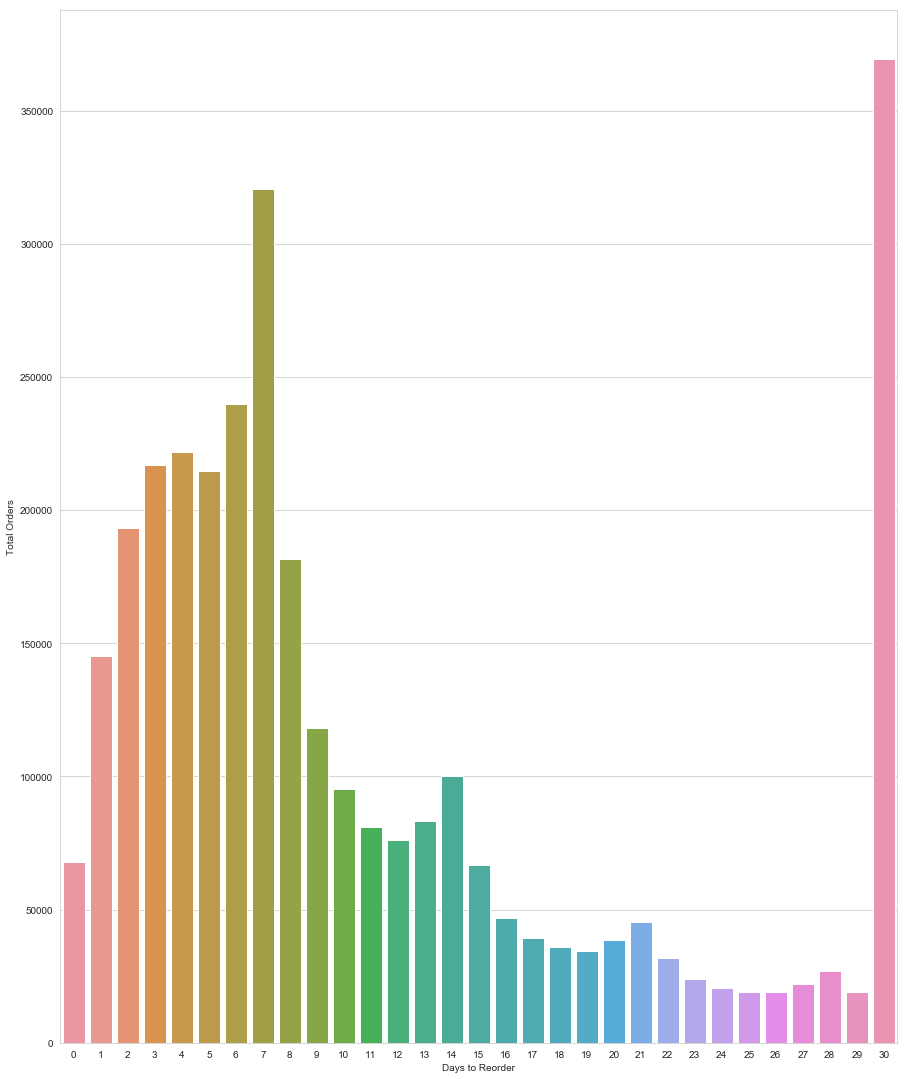

In [16]:
grouped = orders.groupby('days_since_prior_order')['order_id'].agg('count').reset_index()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize = (15,19))
sns.barplot(x = 'days_since_prior_order', y = 'order_id', data = grouped)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel('Days to Reorder')
plt.ylabel('Total Orders')
plt.show()

Customers on average order once a week. Assuming 30 is not an aggregate meaning 30+ we can also conclude if customers are not weekly shoppers with us they are monthly shoppers. 

The last insight we can mine from 'orders' is how many orders a typical customer makes. 
>Put more strategically, after how many orders can we expect a customer to churn? 

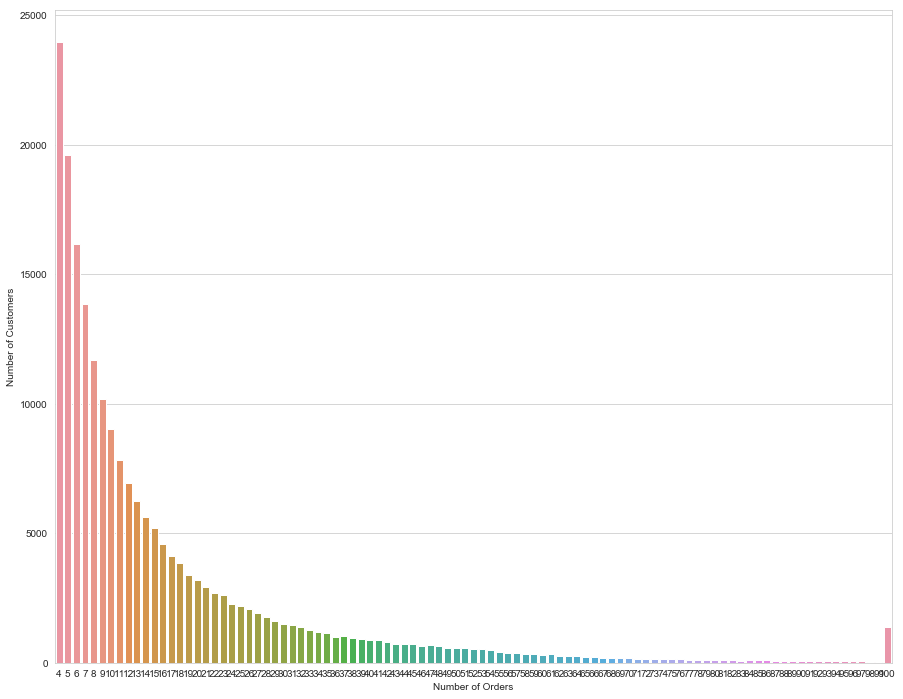

In [17]:
grouped = orders.groupby('user_id')['order_id'].agg('count')
grouped = grouped.value_counts()

f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.values)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

The most likely time a new customer is going to churn is after the 4th order. Perhaps we should give them something free if they make a 5th order. Maybe combine that with an online punch card that awards them again on their 10th order. 
As you can see from the 100 bar at the far right, if we can keep them around long enough, the shopping experience will become a habit and customers will continue to buy from us; on average every 7 days as our earlier chart showed.
<a name='PDA'></a>
## Products, Departments & Aisles 
At this point we have a good idea of our customers buying behavior and favorite products. 

Now, we'll move the focus inward and explore our store inventory. In which department do we offer the most products? Which aisle generates the most sales? We'll cover these questions and more right after we merge our products, departments, and aisles tables together into one nice and clean dataframe. 

In [18]:
items = products.merge(departments, how='left', on='department_id')
items = items.merge(aisles, how='left', on='aisle_id')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


<a name='DMP'></a>
## Departments with The Most Products

In [19]:
grouped = items.groupby('department')['department_id'].agg({'total_products': 'count'}).reset_index()
grouped['percent_of_inv'] = grouped['total_products'].apply(lambda x: x / grouped['total_products'].sum())
grouped = grouped.sort_values(by='total_products', ascending=False)
grouped.head()

,department,total_products,percent_of_inv
17,personal care,6563,0.132084
20,snacks,6264,0.126067
16,pantry,5371,0.108095
3,beverages,4365,0.087848
10,frozen,4007,0.080643


<function matplotlib.pyplot.show(*args, **kw)>

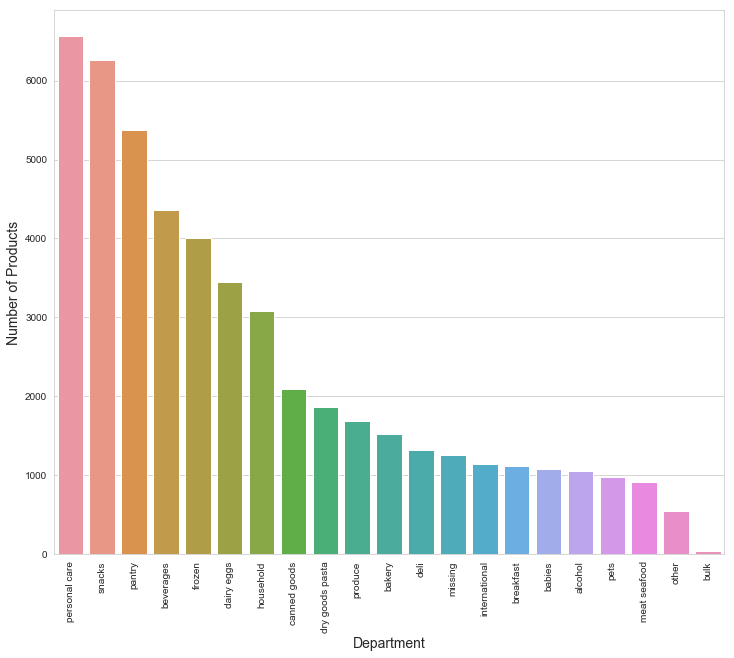

In [20]:
f, ax = plt.subplots(figsize=(12,10))
sns.barplot(x='department', y='total_products', data=grouped)
plt.xticks(rotation='vertical')
plt.xlabel('Department', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.show

Given the variety of affordable personal care items and snack items out there. It makes sense that we store a greater variety of those type of items more than anything else.
<a name='MPPA'></a>
## Most Products Per Aisle
So we know which departments have more products than others, but what are those products? Let's generate plots of each department to see which aisles in each department we stock the most. We'll stick to our top 2 departments.

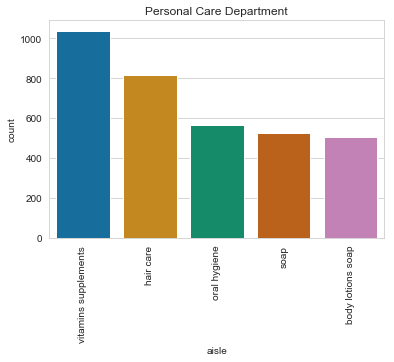

In [21]:
g1 = items.groupby(["department", "aisle"], as_index=False).size().reset_index(name="count")
g2 = g1.loc[g1['department'] == 'personal care']
g2 = g2.sort_values(by='count', ascending=False)[:5]
current_palette = sns.color_palette('colorblind')
sns.set_palette(current_palette)
sns.barplot(x='aisle', y='count', data=g2)
plt.xticks(rotation='vertical')
plt.title('Personal Care Department')
plt.show()

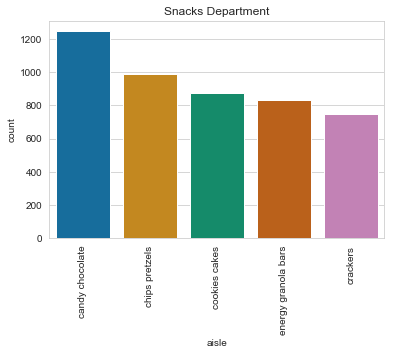

In [22]:
g2 = g1.loc[g1['department'] == 'snacks']
g2 = g2.sort_values(by='count', ascending=False)[:5]
current_palette = sns.color_palette('colorblind')
sns.set_palette(current_palette)
sns.barplot(x='aisle', y='count', data=g2)
plt.xticks(rotation='vertical')
plt.title('Snacks Department')
plt.show()

Vitamin supplements and candy chocolates make the top two.

<a name='AMP'></a>
## Aisle's with The Most Products (Top 10)

Now let's remove the top department criteria and look at aisle product count independent of department. 

In [23]:
grouped = items.groupby('aisle')['product_id'].agg({'total_products': 'count'}).reset_index()
grouped['ratio'] = grouped['total_products'].apply(lambda x: x /grouped['total_products'].sum())
grouped = grouped.sort_values(by='total_products', ascending=False)[:10]
grouped

,aisle,total_products,ratio
85,missing,1258,0.025318
18,candy chocolate,1246,0.025076
71,ice cream ice,1091,0.021957
130,vitamins supplements,1038,0.020890
133,yogurt,1026,0.020649
25,chips pretzels,989,0.019904
125,tea,894,0.017992
93,packaged cheese,891,0.017932
59,frozen meals,880,0.017711
31,cookies cakes,874,0.017590


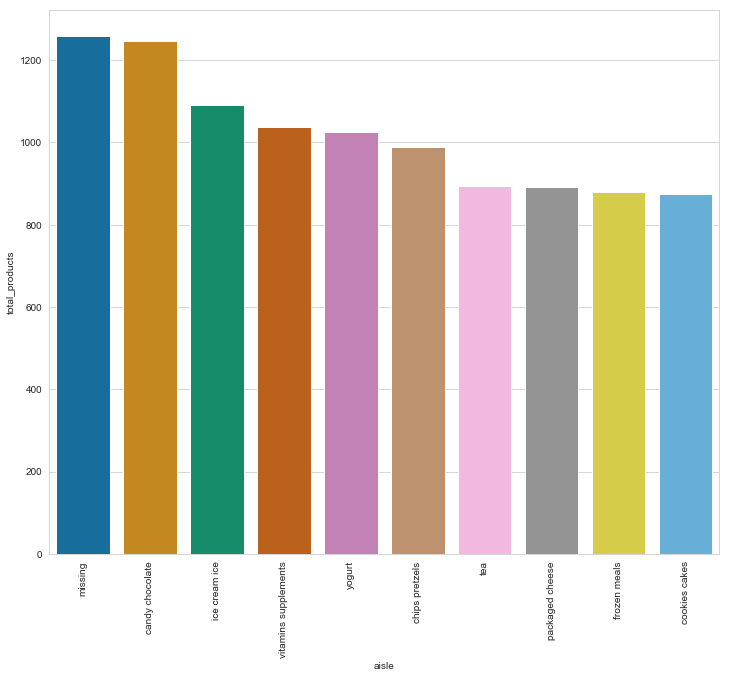

In [24]:
f, ax = plt.subplots(figsize=(12,10))
sns.barplot(x='aisle', y='total_products', data=grouped)
plt.xticks(rotation='vertical')
plt.show()

<a name='BSD'></a>
## Best Selling Department
We might carry a lot of personal care items but does that make it the most profitable department?

We don't have data on revenue so we can't say which department is the most profitable, but by looking at total orders made by department we can at least know which ones are generating the most sales. 

In [25]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [26]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [27]:
order_products = orders[['user_id', 'order_id']].merge(opa[['order_id', 'product_id']],
                                                 how='inner', on='order_id')
order_products = order_products.merge(items, how='inner', on='product_id')

grouped = order_products.groupby('department')['order_id'].agg({'total_orders': 'count'}).reset_index()
grouped['ratio'] = grouped['total_orders'].apply(lambda x: x / grouped['total_orders'].sum())
grouped = grouped.sort_values(by='total_orders', ascending=False)
grouped

,department,total_orders,ratio
19,produce,9888378,0.292390
7,dairy eggs,5631067,0.166505
20,snacks,3006412,0.088897
3,beverages,2804175,0.082917
10,frozen,2336858,0.069099
16,pantry,1956819,0.057861
2,bakery,1225181,0.036227
6,canned goods,1114857,0.032965
8,deli,1095540,0.032394
9,dry goods pasta,905340,0.026770


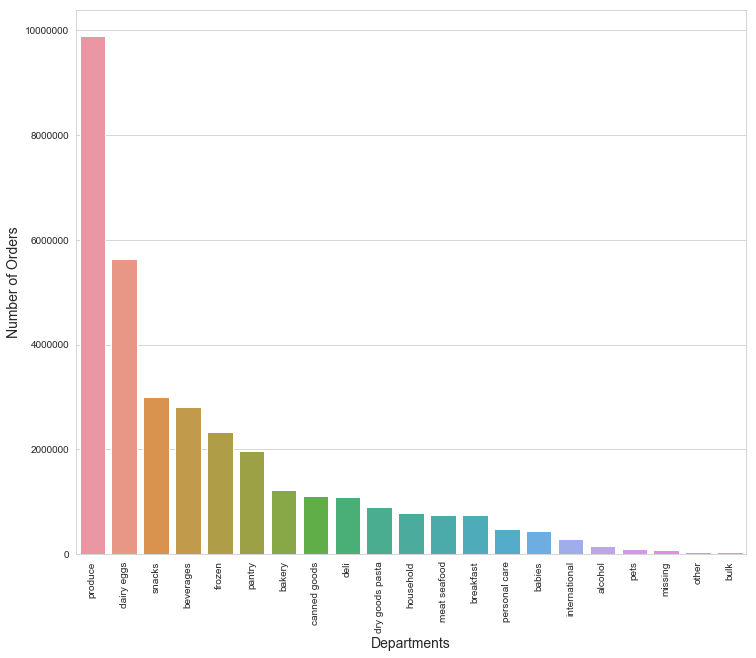

In [28]:
f, ax = plt.subplots(figsize=(12,10))
sns.barplot(x='department', y='total_orders', data=grouped)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xticks(rotation='vertical')
plt.xlabel('Departments', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.show()

Happy to see produce as the most ordered department by a long margin. But what produce are we really talking about here? Let's break it down by aisle.
<a name='BSABSD'></a>
## Best Selling Aisles in Best Selling Department

In [29]:
g1 = order_products.groupby(['department', 'aisle'], as_index=False).size().reset_index(name="count")
g2 = g1.loc[g1['department'] == 'produce']
g2 = g2.sort_values(by='count', ascending=False)[:5]
g2

,department,aisle,count
118,produce,fresh fruits,3792661
120,produce,fresh vegetables,3568630
122,produce,packaged vegetables fruits,1843806
119,produce,fresh herbs,393793
121,produce,packaged produce,289488


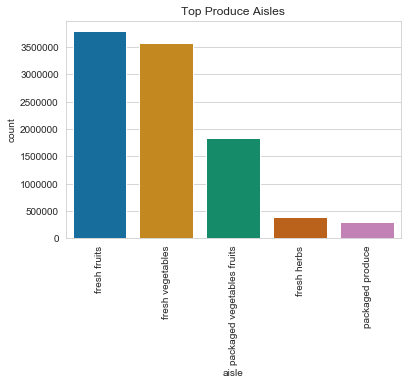

In [30]:
current_palette = sns.color_palette('colorblind')
sns.set_palette(current_palette)
sns.barplot(x='aisle', y='count', data=g2)
plt.xticks(rotation='vertical')
plt.title('Top Produce Aisles')
plt.show()

<a name='BSAO'></a>
## Best Selling Aisles Overall
Our last exploration will be into the top aisles independent of department.

In [31]:
grouped = order_products.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
50,fresh fruits,3792661,0.112146
53,fresh vegetables,3568630,0.105521
98,packaged vegetables fruits,1843806,0.054520
133,yogurt,1507583,0.044578
93,packaged cheese,1021462,0.030204
83,milk,923659,0.027312
131,water seltzer sparkling water,878150,0.025966
25,chips pretzels,753739,0.022287
119,soy lactosefree,664493,0.019648
11,bread,608469,0.017992


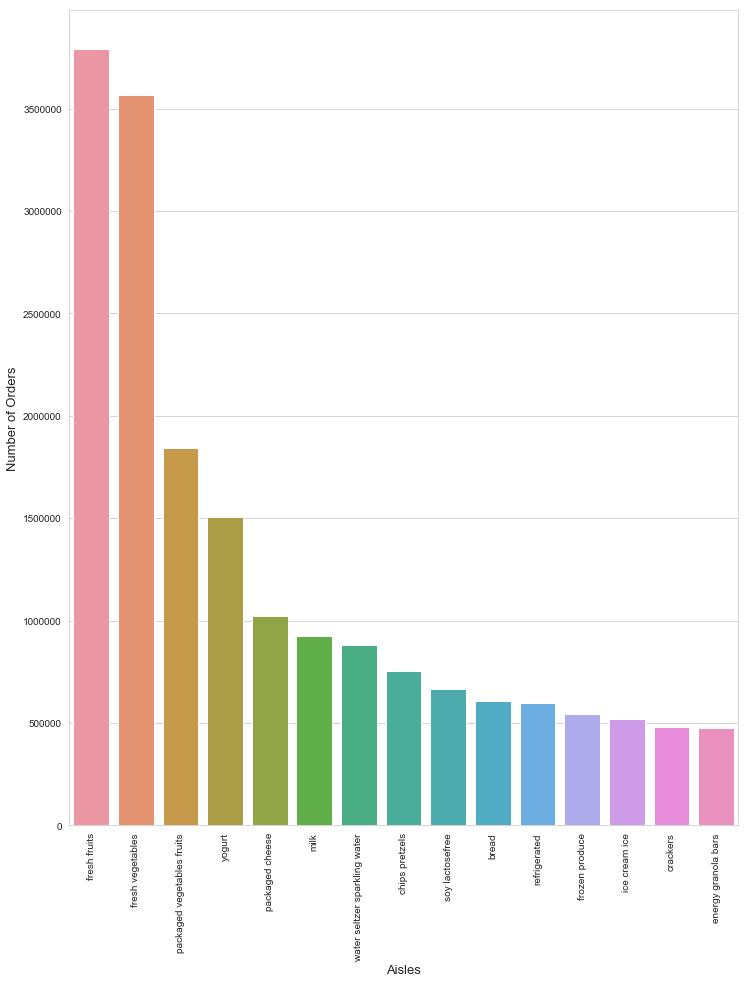

In [32]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

Fresh fruit and vegetables make up 20% of all orders.